In [1]:
import re
from os import path
from time import time

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
666077,1160906523729678339,dona do meu amor todinho. 💜,0.656017,1
154849,1559878647493828611,ansiosa demaisss pro ensaio de miguelito 🥰😍,0.677937,1
221130,1559906349579964417,porra só hj já vi uns tts a dizer que rapazes ...,0.662905,1
815912,1161204627892789249,", dias... mas sem cólica ta 😘🤣",0.701754,1
475380,1160635013731368960,"uma semana no sudas e não acontece nada, mal c...",-0.374729,-1
249481,1559917000729698306,"olá , adoraria escutar “xodó” da juliette, em ...",0.539230,1
244417,1559915146755166211,taehyung muito “a de hoje tá paga 🔥💪🏻😎”,1.188867,1
795575,1161127866626715650,n faço a mínima ideia 😂,0.220968,0
608083,1160784441045868545,só queria que meu pai ligasse pra mim 💔,-0.121951,-1
900190,1161397186925662208,tá calmo daqui da caixa 😎 tá ✌,0.957515,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [substring for substring in string_tratada.split() if substring not in stopwords]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join([stemmer.stem(substring) for substring in string_tratada.split()])

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

103    houvessem
136         pela
12           com
85         haver
137        pelas
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: muito eu ontem😂

Tweet Limpo   : ontem

Tweet Stemed  : ont


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
301542,1559957893847437314,vei pelo amor de deus vai dormir logo vc traba...,-0.313433,-1,vei am deu vai dorm log vc trabalh ced
408901,1160326268602261505,"calou a boca de muita gente , siga para o topo...",0.742358,1,cal boc muit gent sig top merec boy
462635,1160623080944873472,vamos😏😈kkk,0.600150,1,vam kkk
313128,1559962520185700352,tanto falam dos outros afinal… tazonde ronaldo 😂😂,0.441937,1,tant fal outr afinal tazond ronald
190278,1559894173192691715,editor kita ar 👀👀,0.126829,0,edit kit ar


# Modelo Probabilidade das Ocorrencias

Este modelo é uma variação da Soma das Frequencias.

Vamos transformar o texto numa representação vetorial utilizando a probabilidade da ocorrencia que cada palavra aparece nos tweets por rótulo.

## Gerar dicionário de frequencias

Basicamente criaremos três dicionários, um positivo, um negativo e um neutro.

Cada dicionário terá a soma das vezes que a palavra aparece em seu respectivo rótulo (positivo, negativo ou neutro) em todo o dataset.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

In [11]:
# Aqui vamos criar nosso dicionário
def gerador_dicionario_tweet(tweet, dicionario):
    words = tweet.split()

    for word in words:
        dicionario[word] = dicionario.get(word, 0) + 1

In [12]:
dicionario_positivo = {}

X_train[X_train["label"] == 1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_positivo)
)

print("Chaves: {}".format(len(dicionario_positivo.keys())))

Chaves: 58366


In [13]:
dicionario_neutro = {}

X_train[X_train["label"] == 0]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_neutro)
)

print("Chaves: {}".format(len(dicionario_neutro.keys())))

Chaves: 27524


In [14]:
dicionario_negativo = {}

X_train[X_train["label"] == -1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_negativo)
)

print("Chaves: {}".format(len(dicionario_negativo.keys())))

Chaves: 32001


### Visualização dos Dicionários

In [15]:
dicionarios = pd.DataFrame([
    pd.Series(dicionario_positivo, name="positivo"),
    pd.Series(dicionario_neutro, name="neutro"),
    pd.Series(dicionario_negativo, name="negativo")
]).T

In [16]:
dicionarios.sample(10)

,positivo,neutro,negativo
pany,1.0,NaN,NaN
naiur,1.0,NaN,NaN
infenr,NaN,NaN,1.0
marisque,1.0,NaN,NaN
oc,33.0,7.0,5.0
edersonrahn,1.0,NaN,NaN
volteret,1.0,NaN,NaN
xj,2.0,NaN,2.0
parkkk,NaN,1.0,NaN
kkakkakak,NaN,1.0,NaN


## Gerar dicionário das probabilidades

A partir do dicionário de frequencias, vamos gerar o dicionário de probabilidades.

Basicamente, vamos dividir a frequencia que uma palavra aparece em determinado rótulo pela quantidade de palavras naquele rótulo.

Porém, para evitar que tenhamos probabilidade zero, aplicaremos uma Suavização Laplaciana.

In [17]:
def gerar_probabilidades(serie, total_ocorrencias_dimensao, tamanho_vocabulario):
    serie = serie.fillna(0)
    return (serie + 1)/(total_ocorrencias_dimensao + tamanho_vocabulario)

In [18]:
dicionarios["positivo"] = gerar_probabilidades(
    dicionarios["positivo"],
    dicionarios["positivo"].sum(),
    dicionarios.shape[0]
)

In [19]:
dicionarios["negativo"] = gerar_probabilidades(
    dicionarios["negativo"],
    dicionarios["negativo"].sum(),
    dicionarios.shape[0]
)

In [20]:
dicionarios["neutro"] = gerar_probabilidades(
    dicionarios["neutro"],
    dicionarios["neutro"].sum(),
    dicionarios.shape[0]
)

### Visualização do Dicionário

In [21]:
dicionarios.sample(10)

,positivo,neutro,negativo
barakat,8.938971e-07,0.000002,9.102204e-07
viiirr,8.938971e-07,0.000002,9.102204e-07
talonflam,8.938971e-07,0.000002,9.102204e-07
dirgram,4.469485e-07,0.000003,9.102204e-07
suel,9.385920e-06,0.000005,1.274309e-05
faculdad,1.810142e-04,0.000294,4.514693e-04
brigadãoo,8.938971e-07,0.000002,9.102204e-07
agon,1.162066e-05,0.000064,1.010345e-04
pik,5.676247e-05,0.000048,2.184529e-05
hbottom,8.938971e-07,0.000002,9.102204e-07


## Gerar feature vector

Aqui nós transformaremos os textos em um vetor para podermos utilizá-los em um aprendizado supervisionado.

Nosso vetor será representado em três dimensões, uma para positivo, uma para negativo e outro para neutro.

O valor de cada dimensão é definido como o somatório das frequencias de cada palavra do tweet no dicionário da dimensão (positivo, negativo, neutro)

In [22]:
def gerar_feature_vector(string, df):
    tokens = string.split()

    # Calcula o valor de cada dimensão do vetor
    feature_positiva = sum([df["positivo"].get(word, 0) for word in tokens])
    feature_neutra = sum([df["neutro"].get(word, 0) for word in tokens])
    feature_negativa = sum([df["negativo"].get(word, 0) for word in tokens])

    return pd.Series(
        [feature_positiva, feature_neutra, feature_negativa],
        index=["positiva", "neutra", "negativa"],
    )

### Demonstração da Geração do Feature Vector

In [23]:
tweet = X_train["cleaned"].sample(1).values[0]
feature_vector = gerar_feature_vector(tweet, dicionarios)

print("Tweet: {}".format(tweet))
feature_vector

Tweet: qu telefon


positiva    0.001413
neutra      0.001534
negativa    0.001514
dtype: float64

### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [24]:
# Gerar Features Train
features_train = X_train["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(x, dicionarios)
)
features_train["label"] = X_train["label"]

In [25]:
features_train.sample(5)

,positiva,neutra,negativa,label
707127,0.000142,0.000226,0.000094,1
906710,0.007082,0.006487,0.006485,1
620541,0.043004,0.025390,0.030476,1
531690,0.008623,0.004791,0.005903,1
685374,0.007700,0.007958,0.007591,1


In [26]:
X_features_train = features_train[["positiva", "neutra", "negativa"]]
X_features_train.sample(5)

,positiva,neutra,negativa
380242,0.001244,0.001472,0.001816
846821,0.014697,0.010066,0.009614
111414,0.025300,0.021095,0.028736
751972,0.000719,0.000892,0.001318
676354,0.003294,0.003338,0.004365


In [27]:
y_features_train = features_train["label"]
y_features_train.sample(5)

715982   -1
681359    1
680351    1
878137    1
179699    1
Name: label, dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [28]:
# Gerar Features Teste
features_test = X_test["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(x, dicionarios)
)
features_test["label"] = X_test["label"]

In [29]:
features_test.sample(5)

,positiva,neutra,negativa,label
698144,0.006041,0.004840,0.003818,-1
713923,0.001412,0.002801,0.010471,-1
444557,0.021908,0.008656,0.011191,1
201992,0.003551,0.003703,0.005118,-1
641495,0.003488,0.002108,0.004448,1


In [30]:
X_features_test = features_test[["positiva", "neutra", "negativa"]]
X_features_test.sample(5)

,positiva,neutra,negativa
380159,0.004206,0.005542,0.007842
681539,0.008288,0.009152,0.010779
228330,0.025110,0.019531,0.023836
534029,0.001099,0.001307,0.001744
100785,0.010568,0.011145,0.008866


In [31]:
y_features_test = features_test["label"]
y_features_test.sample(5)

142845    1
171551    1
743532    0
658511   -1
197022   -1
Name: label, dtype: int64

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [32]:
# Inicializar o Scaler
scaler = StandardScaler()

# Treinar o Scaler
scaler.fit(X_features_train)

StandardScaler()

In [33]:
# Transformar o conjunto de treinamento
transformed = scaler.transform(X_features_train)

# Gerar um dataframe com a saída do scaler
X_features_train_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_train_scaled.sample(5)

,positiva,neutra,negativa
369734,-0.237727,-0.155085,-0.308791
326065,-0.746549,-0.715141,-0.790707
297576,0.456425,1.066401,1.509656
658074,-0.357228,-0.319636,-0.261341
469197,0.058507,-0.652769,-0.579251


In [34]:
transformed = scaler.transform(X_features_test)

# Gerar um dataframe com a saída do scaler
X_features_test_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_test_scaled.sample(5)

,positiva,neutra,negativa
151331,-0.784901,-0.749469,-0.766437
207955,-0.737329,-0.675655,-0.762513
161048,1.263795,0.728917,0.913002
129966,-0.416665,-0.463236,-0.605411
209285,1.032032,1.224023,1.097935


# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [35]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 3.64%


In [36]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 11.62%


In [37]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 43.03%


In [38]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 43.03%


## Logistic Regression

Referências:
- [https://en.wikipedia.org/wiki/Logistic_regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [39]:
log = LogisticRegression(random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [40]:
params = {
    "C": [
        0.47,
        0.53,
        0.59,
        0.61,
        0.67,
        0.71,
        0.73,
        0.79,
        0.83,
        0.89,
        0.97,
        1,
        2,
        3,
        5,
        7,
        9,
        11,
        13,
        17,
        19,
        21,
    ],
    "tol": [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
}

clf = RandomizedSearchCV(log, params, scoring="f1_weighted", n_jobs=-1, random_state=42)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 52.12%


In [41]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [42]:
print("Score Baseline : {:.2f}%".format(baseline_score*100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_*100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score-clf.best_score_)*100))

Score Baseline : 43.03%
Score Modelo   : 52.12%
Diferença      : 9.10%


### Performance no Conjunto de Treino

In [43]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 52.12%


### Curva de Aprendizado

In [44]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

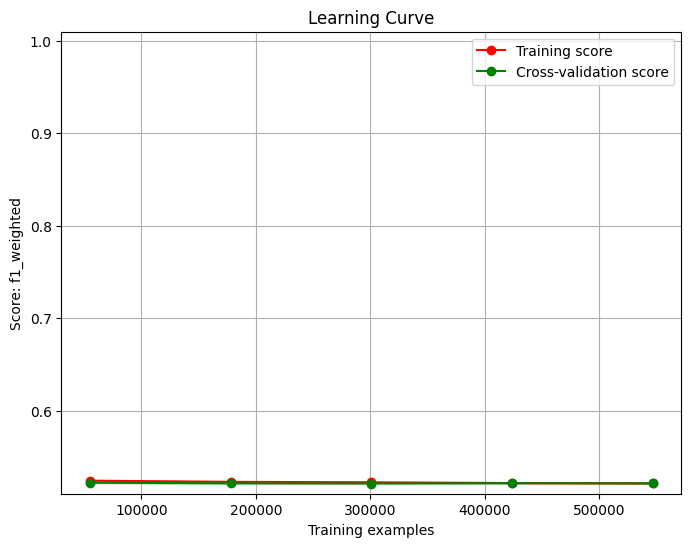

In [45]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Random Forest

Referências:
- [https://en.wikipedia.org/wiki/Random_forest](https://en.wikipedia.org/wiki/Random_forest)
- [https://scikit-learn.org/stable/modules/ensemble.html#forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)

In [46]:
rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

In [47]:
s1 = time()
scores = cross_val_score(
    rf, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
rf_score = scores.mean()

s2 = time()
print("Elapsed Time: ", int(s2 - s1), "seconds")

print("F-Score: {:.2f}%".format(rf_score * 100))

Elapsed Time:  107 seconds
F-Score: 58.92%


In [48]:
rf.fit(X_features_train_scaled, y_features_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=200, n_jobs=-1, random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search]

In [49]:
# Codigo
#rf = RandomForestClassifier(random_state = 42, n_jobs = -1)
#params = {
#   'n_estimators': [100,200,300],
#   'min_samples_split': [2,3,4,5],
#   'min_samples_leaf': [1,2,3,4],
#}

#clf = RandomizedSearchCV(rf, params, scoring='f1_weighted', random_state=42)
#clf.fit(X_features_train_scaled, y_features_train)

#print("Best F-Score: {:.2f}%".format(clf.best_score_*100))

In [50]:
#clf.best_params_
print({'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2})

{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2}


In [51]:
# rf = clf.best_estimator_

#### Comparação com Métrica base

In [52]:
print("Score Baseline : {:.2f}%".format(baseline_score*100))
print("Score Modelo   : {:.2f}%".format(rf_score*100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score-rf_score)*100))

Score Baseline : 43.03%
Score Modelo   : 58.92%
Diferença      : 15.90%


### Performance no Conjunto de Treino

In [53]:
y_pred = rf.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 90.28%


### Curva de Aprendizado

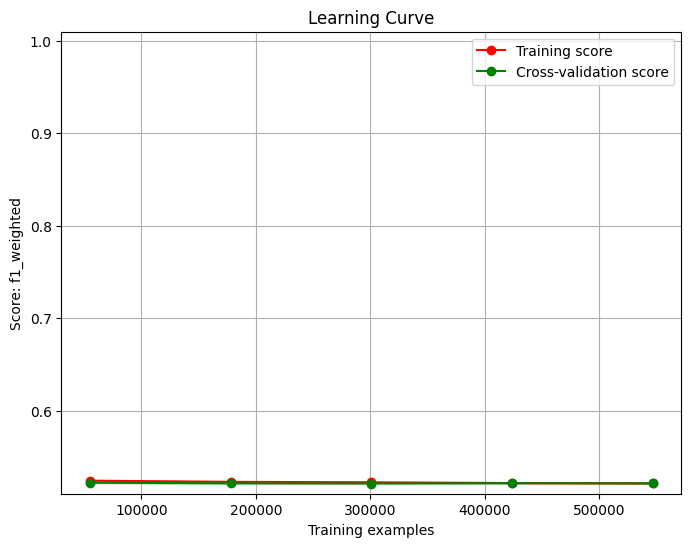

In [54]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Validação em conjunto de Teste

In [55]:
y_pred = rf.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 58.73%


### Preditos Positivos

In [56]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [57]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['o casal de gay aqui na loja se chamando de amor q fofos 💔',
       'sim, concordo e fico chateado ao ver tal matéria sobre alguém do partido... 😔',
       'infelizmente ele eh um garoto mt toxico nem p me dar bola 😭',
       'todo dia vivi me manda msg pra ver se fui pra academia 😐',
       'vais comer sim senhora 🔫 se for comida saudável não ganhas peso',
       'vai entender nen fala comigo e agr está me seguindo no instagram 😕',
       'você 😔', 'tem dias q eu choro como se tivesse sido ontem 💔',
       'ou eu serei a pessoa mais feliz do mundo hoje ou a mais triste tudo depende dele 😭🇭🇺',
       'baby, vou te contar... nunca saiu 😭'], dtype=object)

#### Falso Positivo -> Neutro

In [58]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['vamo faze campeonato de arroto pelo direct do insta? eu ganho 😂 — euem, só arroto na cara dos meus amigos',
       'atento pelo conteúdo 👀 era uma máscara, peruca e óculos?',
       'agora e a hora. 😂', 'teve duas vitimas 😥',
       'mesa real 😂 apesar de ser um pouco de quase tudo daí huauhauhau',
       'olá rapazes, estão preparados para ana castela 💥 é hojeee',
       'parece a ou será ela?😳',
       'eu te entendo mas fala so pra nós quem levou a cocaína do frouxo 😅',
       'fui ver a mary com o dennys, dps passei lá no meu pai 😅',
       'todo mundo vendendo o ingresso do garota vip, o que aconteceu galerinha? 😂'],
      dtype=object)

#### Verdadeiro Positivo

In [59]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['meu abusado 😍 amo sem fim 👨\u200d👦', 'te amo nem ❤',
       'meta - respostas aqui com: oi , você poderia coreografar uma dança pra usarmos com "lobby" no tiktok? pode ser com esse trecho ou com outro verso, a música sai amanhã a noite. ✨',
       'to com sdd de vc falando putaria pra mim 💙',
       'só desces na minha consideração 😚', 'bom diaa, boa sorte tsu!!!💗',
       'ganda neto😩❤', 'vou voltar pra igreja ❤',
       'ele está voltando. ✊🏿✊🏿✊🏿🔥🔥🔥❤️❤️❤️', 'obrigadaa 💙'], dtype=object)

### Preditos Negativos

In [60]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [61]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['pra você ó \U0001faf6🏽💜\U0001faf6🏽',
       'é normal se incomodar com o passado, ter ciúmes do ex namorado, mas já falei que ela não é nada pra mim 🎶',
       'meus shines ✨', 'morri aqui 😍\U0001f979',
       'a cara da merda, vou c % da banca 👍',
       'nada de desanimar,ainda tem mt coisa pra acontecer ⚽',
       'a quarta em dobro do wine n’ massas dispõe de uma vasta seleção de pratos deliciosos na versão para pessoas, com o preço promocional do prato para pessoa. não dá pra perder, né? 😉 peça já o seu pelo nossos canais de atendimento!',
       '“quando vc não consegue dormir é pq tem alguém dormindo pensando em vc” pfvr quem está dormindo faz favor de acordar pq eu quero dormir ✨',
       'hoje o sistema ta querendo me derrubar 🤡😂😂',
       'dormi agarrada com meu grude 💓'], dtype=object)

#### Falso Negativo -> Neutro

In [62]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['mano é cada coisa besta que me deixa mal... 😢',
       'se não for p namorar assim nem quero 😂',
       'irmã então pq tu n usa as coisas q eu já te dei? 👀',
       'tava com fome 😅', 'já foi meu querido! só esperar o green! 🔥',
       'vou me arrepender mas faz muito tempo que nao posto nada nesse site 😅',
       'já to vendo a liniker me xingando o usando encontrar ela 👀',
       'não aguento mais limpar a casa todo diaaa, quero férias de vida de dona de casa 😥😥🤦🏻\u200d♀️',
       'será que eu consigo, tô nessa dúvida tbm 😂',
       'eu e meu namorado querendo viajar o mundo, mas fica difícil comprando lanche toda semana 😢'],
      dtype=object)

#### Verdadeiro Negativo

In [63]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['pqp eu só me ferro 😒',
       'vou calça algo para comer , to cheia de fome 😩',
       'odeio acordar com pesadelo 😤',
       'eu já n tenho mais paciência com nada nem ninguém, to me tornando o pior tipo de pessoa 😔',
       'volta logo 😭',
       'quando as pessoas não acreditam em nada do que digo e pensam que é brincadeira 😖😖😖',
       'vagabunda 😡',
       'mary disse que eu sou de render muito 🙄🤦🏾\u200d♀️ to pensando até agora pra quem eu rendo 😴',
       'sem sono 😤', 'uehhh, nao pegou o voo ainda?? 😒😂'], dtype=object)

### Preditos Neutros

In [64]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [65]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['galo praça tá lá confia kkk🎈💥🍁🍁', 'sei de nada 😏',
       'sua doida 😂😂😂', 'eu sou mau 😎', 'sou parte do eleitorado tb ❤️😭',
       'já quiseram me derrubar e olha nós aí 🎶', 'brinca muito 😂😂😂',
       'ela tem os olhos do filho 💖💖',
       'achei que não tivesse como piorar, mas teve! 🥰😍',
       'acha que me engana mas é golpe em cima de golpe kkk 😝'],
      dtype=object)

#### Falso Neutro -> Negativo

In [66]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['magui 😭😭😭', 'shame on me que não fui ver a yasmine ontem 💔',
       'manuela já vai fazer anos , parece que foi ontem que nasceu 😩😩',
       'preciso urgentemente recuperar o futebol que perdi segunda 😔',
       'coitada ela foi vítima de seus neurônios. 😭😭😭',
       'acho que ela não me ama mais😔', 'cadê o meu 😩', 'não ligo 😔',
       'me pego pra cristo serio😩', 'queira saber aonde adrielle ta 😒'],
      dtype=object)

#### Verdadeiro Neutro

In [67]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['alguém teria um pacote de macarrão e um molho de tomate pra eu fazer sopa pra mim e pra minha mãezinha por favor 😭? estou doente, tenho câncer em estado avançado, perdi parte da visão e audição 😔 moro com a minha mãe que já é idosa, peço doações por nós 🙏',
       'eu to de olho nas caixas 👀', 'parecidas ou iguais? 😅',
       'ei professor, que denúncia mixuruca foi essa, onde vc falou que até bloqueio vinha? teu conceito no twitter não vale merda. fez denúncias que não deram em porra nenhuma. passando vergonha alheia, hein, professor? aprendeu a usar as aspas nos destaques das palavras, professor? 😂',
       'simbora minha banda 😂', 'bolsonaro usa deus. deus usa lula! 👊🇧🇷',
       'bolsonaro usa deus. deus usa lula! 👊🇧🇷',
       'depende, tem uns que são pesados!. 😹', 'louca 😂', 'palhaça 😂'],
      dtype=object)